In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

# Load and explore one of the CSV files to understand the structure
data_path = Path("../data/source")
csv_files = list(data_path.glob("*.csv"))
print(f"Found {len(csv_files)} CSV files:")
for file in csv_files:
    print(f"  - {file.name}")

# Load the first file to examine structure
if csv_files:
    sample_df = pd.read_csv(csv_files[0])
    print(f"\nSample dataset shape: {sample_df.shape}")
    print(f"\nColumns: {list(sample_df.columns)}")
    print(f"\nFirst few rows:")
    print(sample_df.head())

Found 12 CSV files:
  - 2022_LoL_esports_match_data_from_OraclesElixir.csv
  - 2016_LoL_esports_match_data_from_OraclesElixir.csv
  - 2023_LoL_esports_match_data_from_OraclesElixir.csv
  - 2017_LoL_esports_match_data_from_OraclesElixir.csv
  - 2015_LoL_esports_match_data_from_OraclesElixir.csv
  - 2021_LoL_esports_match_data_from_OraclesElixir.csv
  - 2024_LoL_esports_match_data_from_OraclesElixir.csv
  - 2020_LoL_esports_match_data_from_OraclesElixir.csv
  - 2025_LoL_esports_match_data_from_OraclesElixir.csv
  - 2018_LoL_esports_match_data_from_OraclesElixir.csv
  - 2014_LoL_esports_match_data_from_OraclesElixir.csv
  - 2019_LoL_esports_match_data_from_OraclesElixir.csv

Sample dataset shape: (150588, 164)

Columns: ['gameid', 'datacompleteness', 'url', 'league', 'year', 'split', 'playoffs', 'date', 'game', 'patch', 'participantid', 'side', 'position', 'playername', 'playerid', 'teamname', 'teamid', 'champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5', 'pick1', 'pick2', 'pick3', 'pick4'

In [2]:
def transform_dataset(df):
    """
    Transform the dataset by splitting timestamp fields (at10, at15, at20, at25)
    into separate rows with a minute field
    """
    print("Transforming dataset...")

    # Define the base field names that have timestamps
    timestamp_fields = [
        "goldat",
        "xpat",
        "csat",
        "opp_goldat",
        "opp_xpat",
        "opp_csat",
        "golddiffat",
        "xpdiffat",
        "csdiffat",
        "killsat",
        "assistsat",
        "deathsat",
        "opp_killsat",
        "opp_assistsat",
        "opp_deathsat",
    ]

    # Timestamps available in the data
    timestamps = [10, 15, 20, 25]

    # Fields to keep the same across all rows (non-timestamp fields)
    base_fields = [
        col
        for col in df.columns
        if not any(col.startswith(field) for field in timestamp_fields)
    ]

    transformed_rows = []

    for idx, row in df.iterrows():
        if idx % 10000 == 0:
            print(f"Processing row {idx}/{len(df)}")

        for minute in timestamps:
            new_row = {}

            # Copy base fields
            for field in base_fields:
                new_row[field] = row[field]

            # Add minute field
            new_row["minute"] = minute

            # Add timestamp-specific fields
            for field in timestamp_fields:
                timestamp_col = f"{field}{minute}"
                if timestamp_col in df.columns:
                    new_row[field] = row[timestamp_col]
                else:
                    new_row[field] = np.nan

            transformed_rows.append(new_row)

    print(
        f"Transformation complete. Original rows: {len(df)}, New rows: {len(transformed_rows)}"
    )
    return pd.DataFrame(transformed_rows)


# Load and combine all CSV files
print("Loading all CSV files...")
all_dfs = []
for file in csv_files[:3]:  # Start with first 3 files for testing
    df = pd.read_csv(file)
    print(f"Loaded {file.name}: {df.shape}")
    all_dfs.append(df)

# Combine all dataframes
combined_df = pd.concat(all_dfs, ignore_index=True)
print(f"Combined dataset shape: {combined_df.shape}")

# Transform the dataset
transformed_df = transform_dataset(combined_df)
print(f"Transformed dataset shape: {transformed_df.shape}")
print(f"Columns in transformed dataset: {len(transformed_df.columns)}")
print(f"Sample of new columns: {transformed_df.columns.tolist()[:20]}")

Loading all CSV files...
Loaded 2022_LoL_esports_match_data_from_OraclesElixir.csv: (150588, 164)
Loaded 2016_LoL_esports_match_data_from_OraclesElixir.csv: (50568, 164)
Loaded 2023_LoL_esports_match_data_from_OraclesElixir.csv: (132120, 164)
Combined dataset shape: (333276, 164)
Transforming dataset...
Processing row 0/333276
Processing row 10000/333276
Processing row 20000/333276
Processing row 30000/333276
Processing row 40000/333276
Processing row 50000/333276
Processing row 60000/333276
Processing row 70000/333276
Processing row 80000/333276
Processing row 90000/333276
Processing row 100000/333276
Processing row 110000/333276
Processing row 120000/333276
Processing row 130000/333276
Processing row 140000/333276
Processing row 150000/333276
Processing row 160000/333276
Processing row 170000/333276
Processing row 180000/333276
Processing row 190000/333276
Processing row 200000/333276
Processing row 210000/333276
Processing row 220000/333276
Processing row 230000/333276
Processing ro

In [3]:
def prepare_data_for_logistic_regression(df):
    """
    Prepare the transformed data for logistic regression
    """
    print("Preparing data for logistic regression...")

    # Remove rows with missing target variable
    df_clean = df.dropna(subset=["result"]).copy()
    print(f"After removing rows with missing target: {df_clean.shape}")

    # Select feature columns based on the image description
    feature_columns = [
        "firsttothreetowers",
        "firstbaron",
        "xpdiffat",
        "firstmidtower",
        "golddiffat",
        "diffkillsat",
        "firstdragon",
        "side",
        "diffdeathsat",
        "firsttower",
        "firstblood",
        "csdiffat",
        "diffassistsat",
        "league",
        "minute",
    ]

    # Create diffkillsat, diffdeathsat, diffassistsat if they don't exist
    if "diffkillsat" not in df_clean.columns:
        df_clean["diffkillsat"] = df_clean["killsat"] - df_clean["opp_killsat"]
    if "diffdeathsat" not in df_clean.columns:
        df_clean["diffdeathsat"] = df_clean["deathsat"] - df_clean["opp_deathsat"]
    if "diffassistsat" not in df_clean.columns:
        df_clean["diffassistsat"] = df_clean["assistsat"] - df_clean["opp_assistsat"]

    # Select available feature columns
    available_features = []
    for col in feature_columns:
        if col in df_clean.columns:
            available_features.append(col)
        else:
            print(f"Warning: Column '{col}' not found in dataset")

    print(f"Available features: {available_features}")

    # Get features and target
    X = df_clean[available_features].copy()
    y = df_clean["result"].copy()

    # Handle categorical variables (encode them)
    categorical_cols = X.select_dtypes(include=["object"]).columns
    for col in categorical_cols:
        if col == "side":
            # Binary encoding for side (Blue=0, Red=1)
            X[col] = (X[col] == "Red").astype(int)
        elif col == "league":
            # Label encoding for league
            X[col] = pd.Categorical(X[col]).codes

    # Remove rows with any missing values
    mask = ~(X.isnull().any(axis=1) | y.isnull())
    X = X[mask]
    y = y[mask]

    print(f"Final dataset shape: X={X.shape}, y={y.shape}")
    print(f"Target distribution: {y.value_counts().to_dict()}")

    return X, y


# Prepare the data
X, y = prepare_data_for_logistic_regression(transformed_df)

# Display feature information
print("\\nFeature statistics:")
print(X.describe())

Preparing data for logistic regression...
After removing rows with missing target: (1333104, 120)
Available features: ['firsttothreetowers', 'firstbaron', 'xpdiffat', 'firstmidtower', 'golddiffat', 'diffkillsat', 'firstdragon', 'side', 'diffdeathsat', 'firsttower', 'firstblood', 'csdiffat', 'diffassistsat', 'league', 'minute']
Final dataset shape: X=(184372, 15), y=(184372,)
Target distribution: {0: 92186, 1: 92186}
\nFeature statistics:
       firsttothreetowers     firstbaron       xpdiffat  firstmidtower  \
count       184372.000000  184372.000000  184372.000000  184372.000000   
mean             0.500000       0.477784       0.000000       0.500000   
std              0.500001       0.499508    3780.854164       0.500001   
min              0.000000       0.000000  -20370.000000       0.000000   
25%              0.000000       0.000000   -1486.000000       0.000000   
50%              0.500000       0.000000       0.000000       0.500000   
75%              1.000000       1.000000

In [13]:
class StochasticGradientDescentLogisticRegression:
    """
    Stochastic Gradient Descent for Logistic Regression with fixed learning rate
    """

    def __init__(self, learning_rate=0.01, max_epochs=1000, random_state=42):
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.loss_history = []

    def sigmoid(self, z):
        """Sigmoid activation function with numerical stability"""
        # Clip z to prevent overflow
        z = np.clip(z, -250, 250)  # More conservative clipping
        return 1 / (1 + np.exp(-z))

    def compute_loss(self, X, y):
        """Compute logistic loss for the entire dataset"""
        if hasattr(X, "values"):
            X_vals = X.values
        else:
            X_vals = X
        if hasattr(y, "values"):
            y_vals = y.values
        else:
            y_vals = y

        z = X_vals.dot(self.weights) + self.bias
        predictions = self.sigmoid(z)

        # Add small epsilon to prevent log(0)
        epsilon = 1e-15
        predictions = np.clip(predictions, epsilon, 1 - epsilon)

        # Compute log loss
        loss = -np.mean(
            y_vals * np.log(predictions) + (1 - y_vals) * np.log(1 - predictions)
        )
        return loss

    def fit(self, X, y):
        """
        Fit the logistic regression model using stochastic gradient descent
        """
        np.random.seed(self.random_state)

        # Convert to numpy arrays for faster access
        if hasattr(X, "values"):
            X_vals = X.values
        else:
            X_vals = X
        if hasattr(y, "values"):
            y_vals = y.values
        else:
            y_vals = y

        n_samples, n_features = X_vals.shape

        # Initialize weights and bias with smaller values
        self.weights = np.random.normal(0, 0.001, n_features)  # Smaller initialization
        self.bias = 0.0

        # Store loss history
        self.loss_history = []

        print(f"Starting SGD with learning rate: {self.learning_rate}")

        # Compute initial loss
        initial_loss = self.compute_loss(X, y)
        self.loss_history.append(initial_loss)
        print(f"Initial loss: {initial_loss:.6f}")

        for epoch in range(self.max_epochs):
            # Randomize the order of samples for each epoch
            indices = np.random.permutation(n_samples)

            # Process each sample
            for idx in indices:
                # Get single sample (much faster with numpy arrays)
                xi = X_vals[idx]
                yi = y_vals[idx]

                # Forward pass
                z = np.dot(xi, self.weights) + self.bias
                prediction = self.sigmoid(z)

                # Compute gradients for single sample
                error = prediction - yi
                dw = xi * error
                db = error

                # Update weights and bias
                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db

            # Compute loss less frequently for efficiency
            if epoch % 50 == 0:  # Every 50 epochs
                loss = self.compute_loss(X, y)
                self.loss_history.append(loss)
                print(f"Epoch {epoch}, Loss: {loss:.6f}")

        # Final loss
        final_loss = self.compute_loss(X, y)
        self.loss_history.append(final_loss)
        print(f"Final loss: {final_loss:.6f}")
        return self

    def predict_proba(self, X):
        """Predict class probabilities"""
        if hasattr(X, "values"):
            X_vals = X.values
        else:
            X_vals = X
        z = X_vals.dot(self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X):
        """Make predictions"""
        return (self.predict_proba(X) >= 0.5).astype(int)


# Standardize features for better convergence
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

Training set shape: X=(147497, 15), y=(147497,)
Test set shape: X=(36875, 15), y=(36875,)


In [8]:
X_train

,firsttothreetowers,firstbaron,xpdiffat,firstmidtower,golddiffat,diffkillsat,firstdragon,side,diffdeathsat,firsttower,firstblood,csdiffat,diffassistsat,league,minute
1310732,1.0,1.0,545.0,1.0,414.0,-1.0,1.0,1,1.0,1.0,0.0,31.0,-1.0,29,10
654045,1.0,1.0,1873.0,1.0,1946.0,4.0,0.0,1,-4.0,1.0,0.0,5.0,11.0,5,15
893660,0.0,0.0,-1031.0,0.0,-3561.0,-5.0,1.0,1,5.0,0.0,1.0,-18.0,-10.0,30,10
734062,0.0,0.0,-6521.0,0.0,-6638.0,-1.0,0.0,1,1.0,1.0,0.0,-158.0,-3.0,70,20
1259803,1.0,1.0,7579.0,1.0,6939.0,9.0,1.0,0,-9.0,1.0,1.0,-16.0,21.0,24,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170639,1.0,0.0,-48.0,1.0,3095.0,11.0,1.0,1,-11.0,1.0,1.0,17.0,24.0,9,25
1096988,1.0,1.0,1129.0,1.0,1921.0,2.0,1.0,1,-2.0,1.0,1.0,29.0,1.0,66,10
106984,1.0,1.0,147.0,1.0,1311.0,1.0,0.0,0,-1.0,0.0,1.0,13.0,1.0,32,10
81832,0.0,0.0,-918.0,0.0,-1048.0,-2.0,1.0,0,2.0,0.0,0.0,6.0,-2.0,31,10


In [16]:
# Train models with different learning rates
learning_rates = [0.1, 0.05, 0.01, 0.001]  # New learning rates as requested
models = {}
colors = ["blue", "orange", "green", "red"]

# Use a larger subset for training with more epochs
subset_size = 20000  # Larger subset for more comprehensive training
X_train_subset = X_train.iloc[:subset_size]
y_train_subset = y_train.iloc[:subset_size]

print(f"Training on subset of {subset_size} samples with larger epochs")

for lr in learning_rates:
    print(f"\n{'=' * 50}")
    print(f"Training with learning rate: {lr}")
    print("=" * 50)

    model = StochasticGradientDescentLogisticRegression(
        learning_rate=lr,
        max_epochs=1000,  # Larger epochs as requested
        random_state=42,
    )

    model.fit(X_train_subset, y_train_subset)
    models[lr] = model

    # Test accuracy
    y_pred = model.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    print(f"Test accuracy: {accuracy:.4f}")

print("\nTraining completed for all learning rates!")

Training on subset of 20000 samples with larger epochs

Training with learning rate: 0.1
Starting SGD with learning rate: 0.1
Initial loss: 0.692430
Epoch 0, Loss: 0.386808
Epoch 50, Loss: 0.428758
Epoch 50, Loss: 0.428758
Epoch 100, Loss: 0.406914
Epoch 100, Loss: 0.406914
Epoch 150, Loss: 0.397449
Epoch 150, Loss: 0.397449
Epoch 200, Loss: 0.412310
Epoch 200, Loss: 0.412310
Epoch 250, Loss: 0.365098
Epoch 250, Loss: 0.365098
Epoch 300, Loss: 0.376231
Epoch 300, Loss: 0.376231
Epoch 350, Loss: 0.382831
Epoch 350, Loss: 0.382831
Epoch 400, Loss: 0.386656
Epoch 400, Loss: 0.386656
Epoch 450, Loss: 0.391669
Epoch 450, Loss: 0.391669
Epoch 500, Loss: 0.395768
Epoch 500, Loss: 0.395768
Epoch 550, Loss: 0.378078
Epoch 550, Loss: 0.378078
Epoch 600, Loss: 0.383486
Epoch 600, Loss: 0.383486
Epoch 650, Loss: 0.385425
Epoch 650, Loss: 0.385425
Epoch 700, Loss: 0.393268
Epoch 700, Loss: 0.393268
Epoch 750, Loss: 0.366547
Epoch 750, Loss: 0.366547
Epoch 800, Loss: 0.373602
Epoch 800, Loss: 0.3736

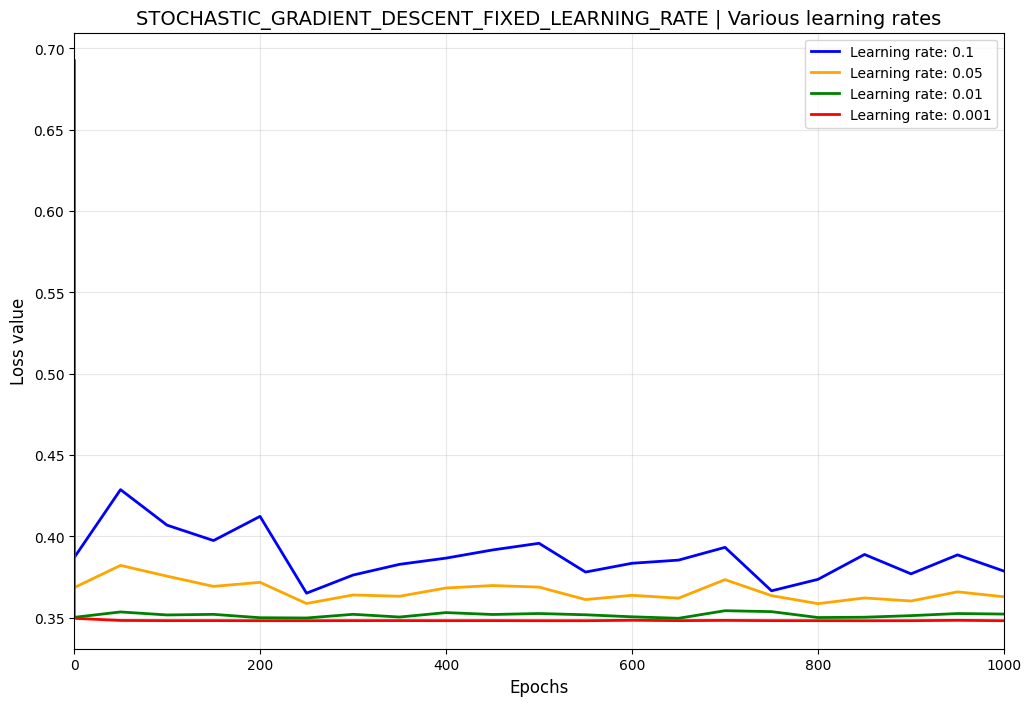


Summary of final results:
Learning rate  0.100: Initial loss: 0.692430, Final loss: 0.378659, Improvement: 0.313771
Learning rate  0.050: Initial loss: 0.692430, Final loss: 0.362879, Improvement: 0.329551
Learning rate  0.010: Initial loss: 0.692430, Final loss: 0.352255, Improvement: 0.340175
Learning rate  0.001: Initial loss: 0.692430, Final loss: 0.348168, Improvement: 0.344262

Testing predictions on first 10 test samples:
LR 0.1: Predictions: [1 1 0 1 1 1 0 0 0 1], Avg probability: 0.556
LR 0.05: Predictions: [1 1 1 1 1 1 0 0 0 1], Avg probability: 0.588
LR 0.01: Predictions: [1 1 1 1 1 1 0 0 0 1], Avg probability: 0.617
LR 0.001: Predictions: [1 1 1 1 1 1 0 0 0 1], Avg probability: 0.618


In [17]:
# Plot loss curves for different learning rates
plt.figure(figsize=(12, 8))

for i, (lr, model) in enumerate(models.items()):
    # Create epoch array based on loss history length
    epochs = []
    loss_values = []

    for j, loss in enumerate(model.loss_history):
        if j == 0:
            epochs.append(0)  # Initial loss
        else:
            epochs.append((j - 1) * 50)  # Loss computed every 50 epochs
        loss_values.append(loss)

    plt.plot(
        epochs, loss_values, color=colors[i], label=f"Learning rate: {lr}", linewidth=2
    )

plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss value", fontsize=12)
plt.title(
    "STOCHASTIC_GRADIENT_DESCENT_FIXED_LEARNING_RATE | Various learning rates",
    fontsize=14,
)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim(0, 1000)  # Updated x-axis limit for 1000 epochs

# Save the plot
output_dir = Path("../data/output")
output_dir.mkdir(exist_ok=True)
plt.savefig(
    output_dir / "sgd_fixed_learning_rate_comparison.png", dpi=300, bbox_inches="tight"
)
plt.show()

# Print summary statistics
print("\nSummary of final results:")
print("=" * 50)
for lr, model in models.items():
    initial_loss = model.loss_history[0]
    final_loss = model.loss_history[-1]
    improvement = initial_loss - final_loss
    print(
        f"Learning rate {lr:6.3f}: Initial loss: {initial_loss:.6f}, Final loss: {final_loss:.6f}, Improvement: {improvement:.6f}"
    )

# Test on a sample to verify predictions work
print(f"\nTesting predictions on first 10 test samples:")
sample_X = X_test.iloc[:10]
for lr, model in models.items():
    predictions = model.predict(sample_X)
    probabilities = model.predict_proba(sample_X)
    print(
        f"LR {lr}: Predictions: {predictions}, Avg probability: {np.mean(probabilities):.3f}"
    )